## Accessing Deltares global flood data

[Deltares](https://www.deltares.nl/en/) has produced a series of global inundation maps of flood depth using a geographic information systems (GIS)-based inundation model that takes into account water level attenuation and is forced by sea level. Multiple datasets were created using various digital elevation models (DEMs) at multiple resolutions under two different sea level rise (SLR) conditions: current (2018) and 2050. 

This dataset is stored in the West Europe Azure region, so this notebook will run most efficiently on Azure compute located in the same region. If you are using this data for environmental science applications, consider applying for an AI for Earth grant to support your compute requirements.

### Environment setup

In [1]:
import math
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import dask.distributed
import pystac_client
import planetary_computer
import rioxarray  # noqa: F401
import contextily
import shapely.geometry
import cartopy.feature as cfeature
import cartopy.crs as ccrs

### Create a local Dask cluster

Enable parallel reads and processing of data using Dask and xarray.

In [2]:
client = dask.distributed.Client(processes=False)
print(client.dashboard_link)

http://192.168.1.84:8787/status


### Data access

The entire dataset is made up of several dozen individual netCDF files, each representing an entire global inundation map, but derived from either a different source DEM, sea level rise condition, or return period. Return periods are occurrence probabilities for floods of a particular magnitude, often referred to as, for example, "a 100 year flood". Use the STAC API to query on these various properties:

To start, we'll load and plot the inundation data produced from the 90m NASADEM at a 100 year return period for 2050 sea level rise conditions. 

In [3]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)
search = catalog.search(
    collections=["deltares-floods"],
    query={
        "deltares:dem_name": {"eq": "NASADEM"},
        "deltares:sea_level_year": {"eq": 2050},
        "deltares:return_period": {"eq": 10},
    },
)

item = next(search.items())
item

<Item id=NASADEM-90m-2050-0010>

This item has two assets: one pointing to the NetCDF file and one pointing to an index file enabling cloud-optimized access.
When accessing the data from Azure, we recommend using the index file.
The additional environment variables are needed to propagate authentication information down to the data access layers.

In [4]:
url = item.assets["index"].href
token = planetary_computer.sign_url(url).split("?")[1]
os.environ["AZURE_STORAGE_SAS_TOKEN"] = token
os.environ["AZURE_STORAGE_ANON"] = "false"
os.environ["AZURE_STORAGE_ACCOUNT_NAME"] = "deltaresfloodssa"
ds = xr.open_dataset(f"reference::{url}", engine="zarr", consolidated=False, chunks={})
ds

<xarray.Dataset> Size: 373GB
Dimensions:     (time: 1, lat: 216000, lon: 432000)
Coordinates:
  * lat         (lat) float64 2MB -90.0 -90.0 -90.0 -90.0 ... 90.0 90.0 90.0
  * lon         (lon) float64 3MB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time        (time) datetime64[ns] 8B 2010-01-01
Data variables:
    inun        (time, lat, lon) float32 373GB dask.array<chunksize=(1, 600, 600), meta=np.ndarray>
    projection  object 8B ...
Attributes:
    Conventions:  CF-1.6
    config_file:  /mnt/globalRuns/watermask_post_NASA90m_rest/run_rp0010_slr2...
    institution:  Deltares
    project:      Microsoft Planetary Computer - Global Flood Maps
    references:   https://www.deltares.nl/en/
    source:       Global Tide and Surge Model v3.0 - ERA5
    title:        GFM - NASA DEM 90m - 2050 slr - 0010-year return level

### Define an area of interest

The data is 90m at a global scale, but most relevant in coastal areas. Let's zoom in a on a flood-prone region of Myanmar by defining a bounding box and clipping our xarray dataset.

In [5]:
myanmar_geojson = {
    "type": "Polygon",
    "coordinates": [
        [
            [93.9385986328125, 15.617746547613212],
            [96.96533203125, 15.617746547613212],
            [96.96533203125, 18.37016593904468],
            [93.9385986328125, 18.37016593904468],
            [93.9385986328125, 15.617746547613212],
        ]
    ],
}

poly = shapely.geometry.shape(myanmar_geojson)
minx, miny, maxx, maxy = poly.bounds
print("AoI bounds:", poly.bounds)

AoI bounds: (93.9385986328125, 15.617746547613212, 96.96533203125, 18.37016593904468)


In [6]:
ds_myanmar = ds.sel(lat=slice(miny, maxy), lon=slice(minx, maxx))
ds_myanmar

<xarray.Dataset> Size: 48MB
Dimensions:     (time: 1, lat: 3303, lon: 3632)
Coordinates:
  * lat         (lat) float64 26kB 15.62 15.62 15.62 15.62 ... 18.37 18.37 18.37
  * lon         (lon) float64 29kB 93.94 93.94 93.94 93.94 ... 96.96 96.96 96.96
  * time        (time) datetime64[ns] 8B 2010-01-01
Data variables:
    inun        (time, lat, lon) float32 48MB dask.array<chunksize=(1, 458, 73), meta=np.ndarray>
    projection  object 8B ...
Attributes:
    Conventions:  CF-1.6
    config_file:  /mnt/globalRuns/watermask_post_NASA90m_rest/run_rp0010_slr2...
    institution:  Deltares
    project:      Microsoft Planetary Computer - Global Flood Maps
    references:   https://www.deltares.nl/en/
    source:       Global Tide and Surge Model v3.0 - ERA5
    title:        GFM - NASA DEM 90m - 2050 slr - 0010-year return level

### Distribution of inundation amounts

For areas with greater than zero inundation, let's bin the data in 1m increments and see how it's distributed. Counting by 90m pixels is a rough estimate of actual area.

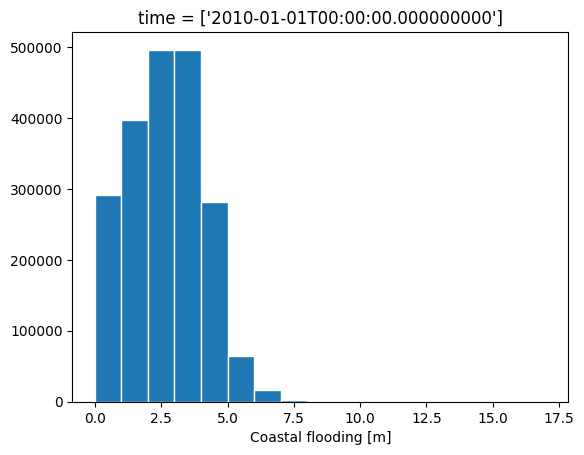

In [7]:
# Select only flooded area
warnings.filterwarnings("ignore", "All-NaN")
flooded = ds_myanmar.inun.where(ds.inun > 0)
num_bins = math.ceil(flooded.max().values)
flooded.plot.hist(bins=range(0, num_bins), edgecolor="w")
plt.show()

### Plot the layer

We can also look at the geographic distribution of inundation. We'll add an Esri imagery basemap for some context in our plot.

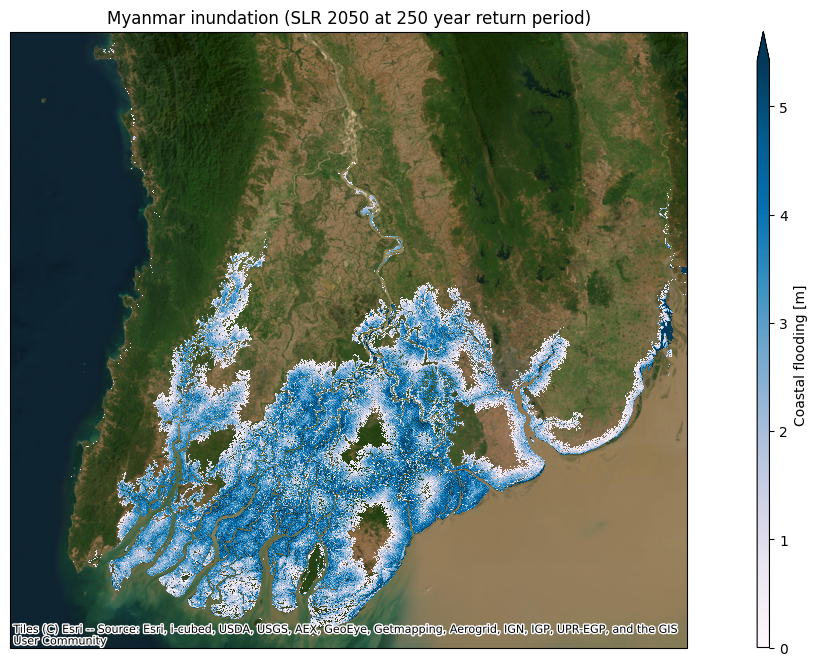

In [8]:
fig = plt.figure(figsize=(18, 8), dpi=100)
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([minx, maxx, miny, maxy])
flooded.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="PuBu",
    cbar_kwargs={"aspect": 50},
    robust=True,
    vmin=0,
)

ax.set_title("Myanmar inundation (SLR 2050 at 250 year return period)")

contextily.add_basemap(
    ax,
    source=contextily.providers.Esri.WorldImagery,
    zoom=10,
    crs=ds.projection.attrs["EPSG_code"],
)

### Working with two sea level rise conditions

We've been looking at the 2050 sea level rise conditions. Let's compare with the current SLR conditions under the same DEM, resolution, and return period.

First we'll read in the other dataset and concatenate to a single xarray dataset.

In [9]:
search = catalog.search(
    collections=["deltares-floods"],
    query={
        "deltares:dem_name": {"eq": "NASADEM"},
        "deltares:sea_level_year": {"eq": 2018},
        "deltares:return_period": {"eq": 10},
    },
)

item = next(search.items())
item

ds_2018 = xr.open_dataset(
    f"reference::{item.assets['index'].href}",
    engine="zarr",
    chunks={},
    consolidated=False,
)

ds_2018_myanmar = ds_2018.sel(lat=slice(miny, maxy), lon=slice(minx, maxx))

In [10]:
# Concat the two datasets along the time dimension
mds = xr.concat([ds_2018_myanmar, ds_myanmar], dim="time")

# Time coordinates are not set in the data files. Set them correctly
# to allow selecting by label.
mds = mds.assign_coords(
    time=np.array([np.datetime64("2018-01-01"), np.datetime64("2050-01-01")])
)
mds

/var/folders/p0/vbz6hyr901z17__1xr798h2w0000gn/T/ipykernel_69000/3067447699.py:6: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  mds = mds.assign_coords(


<xarray.Dataset> Size: 96MB
Dimensions:     (time: 2, lat: 3303, lon: 3632)
Coordinates:
  * lat         (lat) float64 26kB 15.62 15.62 15.62 15.62 ... 18.37 18.37 18.37
  * lon         (lon) float64 29kB 93.94 93.94 93.94 93.94 ... 96.96 96.96 96.96
  * time        (time) datetime64[ns] 16B 2018-01-01 2050-01-01
Data variables:
    inun        (time, lat, lon) float32 96MB dask.array<chunksize=(1, 458, 73), meta=np.ndarray>
    projection  (time) object 16B nan nan
Attributes:
    Conventions:  CF-1.6
    config_file:  /mnt/globalRuns/watermask_post_NASA/run_rp0010_slr2018/coas...
    institution:  Deltares
    project:      Microsoft Planetary Computer - Global Flood Maps
    references:   https://www.deltares.nl/en/
    source:       Global Tide and Surge Model v3.0 - ERA5
    title:        GFM - NASA DEM 90m - 2018 slr - 0010-year return level

#### Plot the two layers

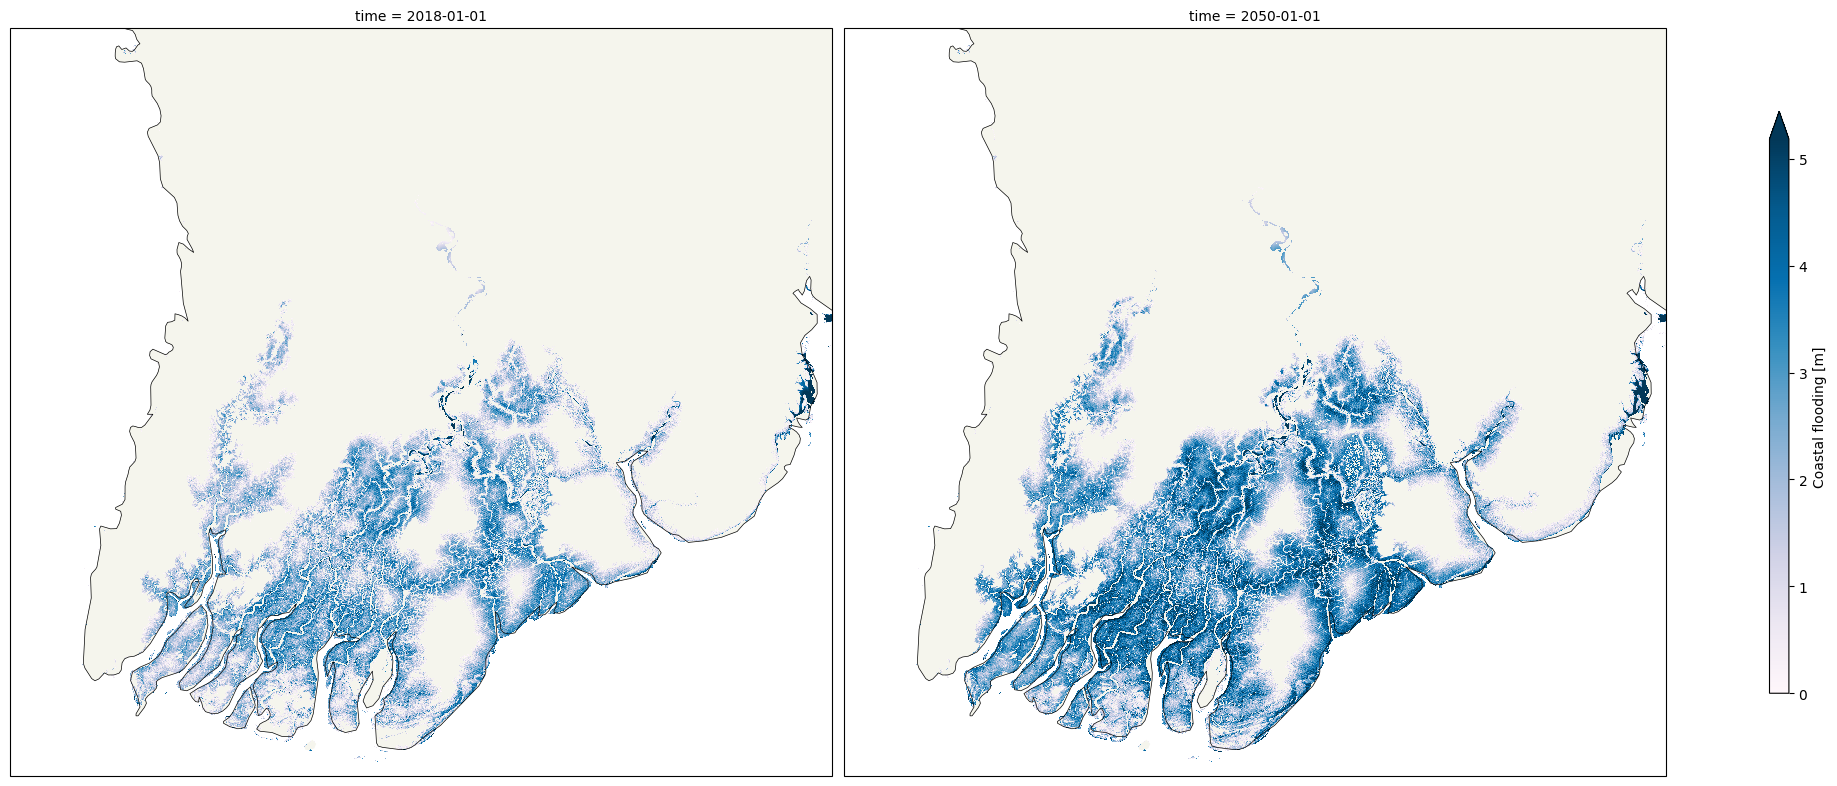

In [15]:
flooded = mds.where(mds.inun > 0).load()

prj = ccrs.PlateCarree()

p = flooded.inun.plot(
    col="time",
    col_wrap=None,
    transform=prj,
    subplot_kws={"projection": prj},
    cmap="PuBu",
    size=10,
    cbar_kwargs={"aspect": 30, "shrink": 0.6},
    robust=True,
    vmin=0,
)

for ax in p.axs.flat:
    ax.coastlines(linewidth=0.5)
    ax.set_extent([minx, maxx, miny, maxy])
    ax.add_feature(cfeature.LAND, zorder=0, linewidth=0.5, facecolor="#f5f5ed")

plt.draw()

#### Compare the distribution of inundation depth by area

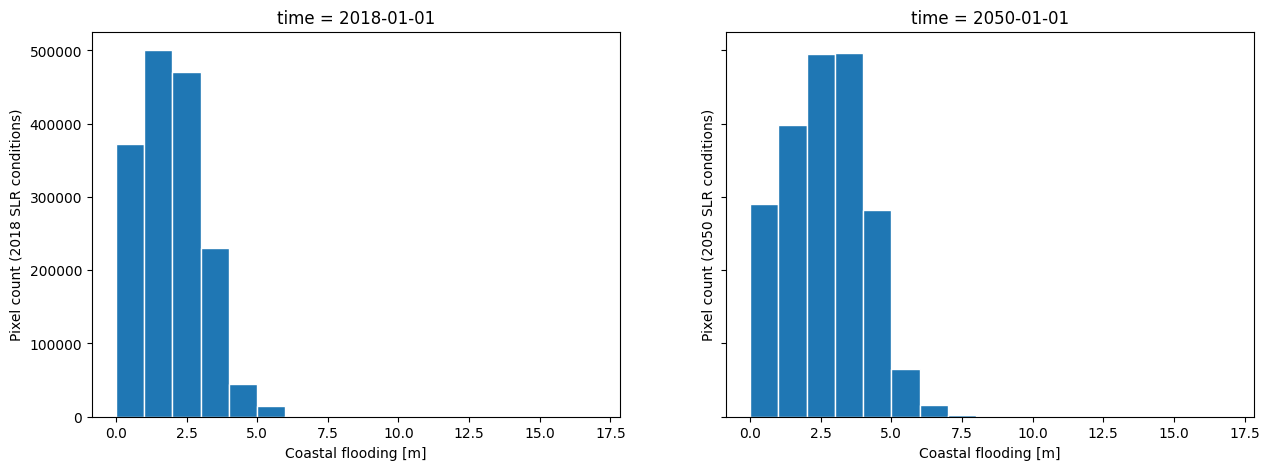

In [12]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5), sharey=True, sharex=True)

for i in range(2):
    num_bins = math.ceil(flooded.inun.max().values)
    year = str(flooded.isel(time=i).time.values)[:4]
    axes[i].set_ylabel(f"Pixel count ({year} SLR conditions)")
    flooded.inun.isel(time=i).plot.hist(
        ax=axes[i], edgecolor="white", bins=range(0, num_bins)
    )

plt.show()

### Plot areas of increased inundation under 2050 sea level rise conditions

It was a bit hard to see predicted changes in inundation in the side-by-side map plots, but the histograms showed a definite increase in the higher bins. Let's calculate the difference and plot just the increase.

In [13]:
diff = mds["inun"].diff("time")
diff = diff.where(diff > 0)

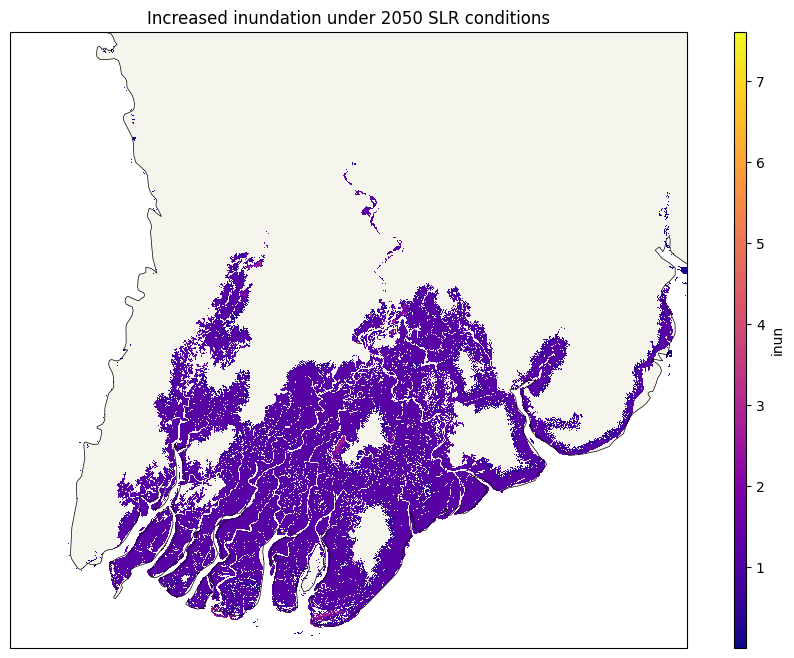

In [14]:
fig, axis = plt.subplots(
    subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(12, 8), dpi=100
)

diff.plot(
    ax=axis,
    transform=ccrs.PlateCarree(),
    cmap="plasma",
    cbar_kwargs={"aspect": 50},
)

plt.title("Increased inundation under 2050 SLR conditions")
axis.coastlines(linewidth=0.5)
axis.set_extent([minx, maxx, miny, maxy])
axis.add_feature(cfeature.LAND, zorder=0, linewidth=0, facecolor="#f5f5ed")

plt.draw()